## Imports and Auxiliary functions

In [ ]:
# imports

import numpy as np
from findiff import FinDiff
import itertools

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
#auxiliary functions that will be needed for all three datasets

def STRidge(X0, y, lam, maxit, tol, normalize=2, print_results=False):
    """
    Sequential Threshold Ridge Regression algorithm for finding (hopefully) sparse
    approximation to X^{-1}y.  The idea is that this may do better with correlated observables.

    This assumes y is only one column
    """

    n, d = X0.shape
    X = np.zeros((n, d), dtype=np.complex64)
    # First normalize data
    if normalize != 0:
        Mreg = np.zeros((d, 1))
        for i in range(0, d):
            Mreg[i] = 1.0 / (np.linalg.norm(X0[:, i], normalize))
            X[:, i] = Mreg[i] * X0[:, i]
    else:
        X = X0

    # Get the standard ridge esitmate
    if lam != 0:
        w = np.linalg.lstsq(X.T.dot(X) + lam * np.eye(d), X.T.dot(y), rcond=None)[0]
    else:
        w = np.linalg.lstsq(X, y, rcond=None)[0]
    num_relevant = d
    biginds = np.where(abs(w) > tol)[0]

    # Threshold and continue
    for j in range(maxit):

        # Figure out which items to cut out
        smallinds = np.where(abs(w) < tol)[0]
        new_biginds = [i for i in range(d) if i not in smallinds]

        # If nothing changes then stop
        if num_relevant == len(new_biginds):
            break
        else:
            num_relevant = len(new_biginds)

        # Also make sure we didn't just lose all the coefficients
        if len(new_biginds) == 0:
            if j == 0:
                if print_results:
                    print("Tolerance too high - all coefficients set below tolerance")
                return w
            else:
                break
        biginds = new_biginds

        # Otherwise get a new guess
        w[smallinds] = 0
        if lam != 0:
            w[biginds] = np.linalg.lstsq(
                X[:, biginds].T.dot(X[:, biginds]) + lam * np.eye(len(biginds)),
                X[:, biginds].T.dot(y),
                rcond=None,
            )[0]
        else:
            w[biginds] = np.linalg.lstsq(X[:, biginds], y, rcond=None)[0]

    # Now that we have the sparsity pattern, use standard least squares to get w
    if biginds != []:
        w[biginds] = np.linalg.lstsq(X[:, biginds], y, rcond=None)[0]

    Mreg = Mreg.reshape(
        w.shape[0],
    )
    if normalize != 0:
        return np.multiply(Mreg, w)  # This return wrong dimension
    else:
        return w


def TrainSTRidge(
    R,
    Ut,
    lam,
    d_tol,
    maxit=25,
    STR_iters=10,
    l0_penalty=None,
    normalize=2,
    split=0.8,
    print_best_tol=True,
):
    """
    This function trains a predictor using STRidge.

    It runs over different values of tolerance and trains predictors on a training set, then evaluates them
    using a loss function on a holdout set.

    Please note published article has typo.  Loss function used here for model selection evaluates fidelity using 2-norm,
    not squared 2-norm.
    """

    # Split data into 80% training and 20% test, then search for the best tolderance.
    np.random.seed(0)  # for consistancy
    n, _ = R.shape
    train = np.random.choice(n, int(n * split), replace=False)
    test = [i for i in np.arange(n) if i not in train]
    TrainR = R[train]
    TestR = R[test]
    TrainY = Ut[train]
    TestY = Ut[test]
    D = TrainR.shape[1]

    # Set up the initial tolerance and l0 penalty
    d_tol = float(d_tol)
    tol = d_tol
    if l0_penalty == None:
        l0_penalty = 0.001 * np.linalg.cond(R)

    # Get the standard least squares estimator
    w = np.zeros((D))
    w_best = np.linalg.lstsq(TrainR, TrainY, rcond=None)[0]
    err_best = np.linalg.norm(
        TestY - TestR @ w_best, 2
    ) + l0_penalty * np.count_nonzero(w_best)
    tol_best = 0

    # Now increase tolerance until test performance decreases
    for iter in range(maxit):

        # Get a set of coefficients and error
        w = STRidge(TrainR, TrainY, lam, STR_iters, tol, normalize=normalize)
        err = np.linalg.norm(TestY - TestR @ w, 2) + l0_penalty * np.count_nonzero(w)

        # Has the accuracy improved?
        if err <= err_best:
            err_best = err
            w_best = w
            tol_best = tol
            tol = tol + d_tol

        else:
            tol = max([0, tol - 2 * d_tol])
            d_tol = 2 * d_tol / (maxit - iter)
            tol = tol + d_tol

    if print_best_tol:
        print("Optimal tolerance:", tol_best)

    return w_best

# DATASET 1

## Loading the data

In [55]:

np.random.seed(0)
data = np.load("AISE-project3-data/1.npz")

u = data["u"]
x = data["x"]
t = data["t"]


Explore the data

<Figure size 640x480 with 0 Axes>

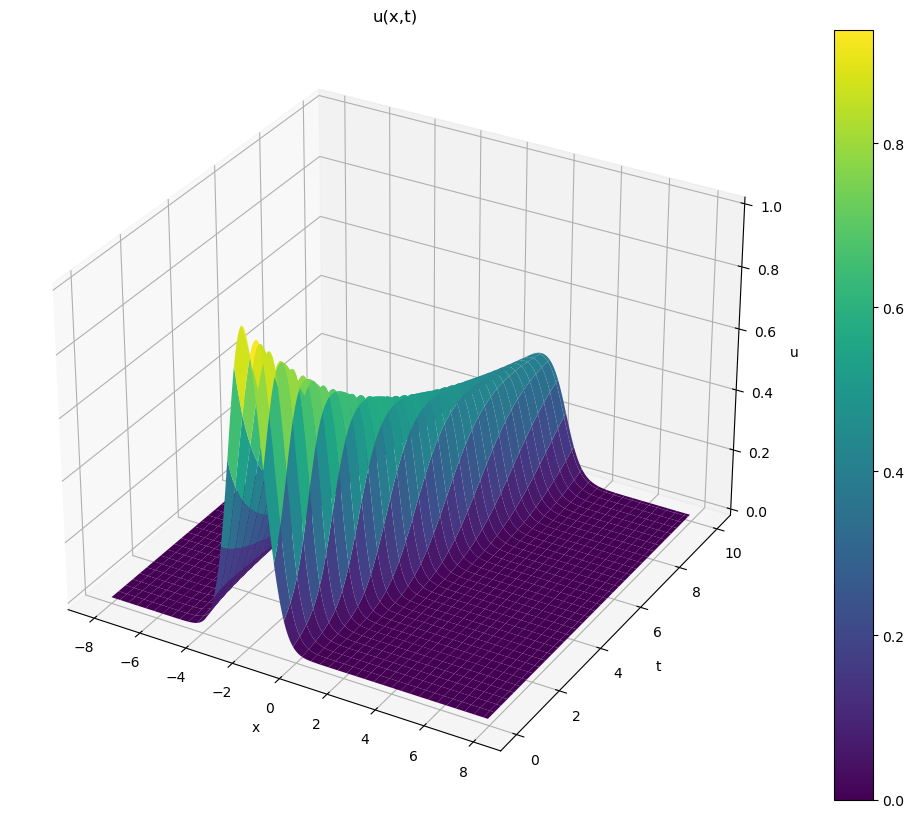

In [56]:

u = data["u"]
x = data["x"]
t = data["t"]

# Plot
fig = plt.figure()
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(x, t, u, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")
ax.set_title("u(x,t)")
fig.colorbar(surf)

plt.show()

In [57]:
t

array([[ 0. ,  0.1,  0.2, ...,  9.8,  9.9, 10. ],
       [ 0. ,  0.1,  0.2, ...,  9.8,  9.9, 10. ],
       [ 0. ,  0.1,  0.2, ...,  9.8,  9.9, 10. ],
       ...,
       [ 0. ,  0.1,  0.2, ...,  9.8,  9.9, 10. ],
       [ 0. ,  0.1,  0.2, ...,  9.8,  9.9, 10. ],
       [ 0. ,  0.1,  0.2, ...,  9.8,  9.9, 10. ]], dtype=float32)

In [58]:
x

array([[-8.    , -8.    , -8.    , ..., -8.    , -8.    , -8.    ],
       [-7.9375, -7.9375, -7.9375, ..., -7.9375, -7.9375, -7.9375],
       [-7.875 , -7.875 , -7.875 , ..., -7.875 , -7.875 , -7.875 ],
       ...,
       [ 7.8125,  7.8125,  7.8125, ...,  7.8125,  7.8125,  7.8125],
       [ 7.875 ,  7.875 ,  7.875 , ...,  7.875 ,  7.875 ,  7.875 ],
       [ 7.9375,  7.9375,  7.9375, ...,  7.9375,  7.9375,  7.9375]],
      dtype=float32)

We can notice that the data are distributed spatially and temporally with a nice pattern, composing a nice lattice. Finite Differenfce methods will be therefore a good and efficient way to find the derivatives of the function

In [59]:
# find out the spacing on the grid in x and t keeping 5 decimal places

print("t spacing:", np.mean(np.unique(np.diff(t[0])), axis=0, keepdims=True))
print("x spacing:", np.mean(np.unique(np.diff(x[:, 0])), axis=0, keepdims=True))

t spacing: [0.09999999]
x spacing: [0.0625]


Therefore we choose a spacing of `0.01` for t and `0.0625` for x

In [60]:
def derivatives_calculator(u, x, t, mixed = False):
    """
    Calculate the first and second order derivatives of u with respect to x and t

    Args:
    u: np.ndarray, the function to differentiate
    x: np.ndarray, the x grid
    t: np.ndarray, the t grid
    mixed: bool, whether to calculate mixed derivatives or not

    Returns:
    dict, a dictionary containing the function and its derivatives

    """
    dx = 0.0625
    dt = 0.1

    u_x = FinDiff(0, dx, 1)(u)
    u_t = FinDiff(1, dt, 1)(u)
    u_xx = FinDiff(0, dx, 2)(u)
    u_xxx = FinDiff(0, dx, 3)(u)

    if mixed:
        u_xt = FinDiff((0, 1), (dx, dt), 1)(u)
        u_xxt = FinDiff((0, 1), (dx, dt), 2)(u)
        u_xtt = FinDiff((0, 1), (dx, dt), 2)(u)

        return {
            "u": u,
            "u_x": u_x,
            "u_xx": u_xx,
            "u_xxx": u_xxx,
            "u_t": u_t,
            "u_xt": u_xt,
            "u_xxt": u_xxt,
            "u_xtt": u_xtt
        }

    return {
        "u": u,
        "u_x": u_x,
        "u_xx": u_xx,
        "u_xxx": u_xxx, 
        "u_t": u_t
    }


derivatives = derivatives_calculator(u, x, t)

In [61]:
def find_ut_Thetau(derivatives, degree):
    """
    Build the Theta matrix for the given derivatives up to a given degree.

    Args:
        derivatives (dict): Dictionary containing the derivatives of u with respect to x and t.
        degree (int): The maximum degree of the polynomial terms to include.

    Returns:
        np.ndarray: The Theta matrix containing the derivatives and polynomial terms.
        list: The descriptions of the columns in Theta.
    """

    # Extract and flatten u_t from the derivatives dictionary
    u_t = derivatives.pop("u_t").flatten()

    # Initialize the Theta matrix with a column of ones and the description list
    Theta_u = np.ones((len(u_t), 1))
    table = ["1"]

    # Include individual derivatives
    for key, value in derivatives.items():
        Theta_u = np.hstack([Theta_u, value.flatten().reshape(-1, 1)])
        table.append(key)

    # Generate polynomial terms up to the given degree
    for d in range(2, degree + 1):
        for combination in itertools.combinations_with_replacement(
            derivatives.keys(), d
        ):
            term = np.prod(
                [derivatives[deriv].flatten() for deriv in combination], axis=0
            )
            desc = " * ".join(combination)
            Theta_u = np.hstack([Theta_u, term.reshape(-1, 1)])
            table.append(desc)

    return u_t, Theta_u, table

u_t, Theta_u, Table = find_ut_Thetau(derivatives, degree=4)

# Print shapes for verification
print("u_t shape:", u_t.shape)
print("Theta shape:", Theta_u.shape)
print("Table:", Table)

u_t shape: (25856,)
Theta shape: (25856, 70)
Table: ['1', 'u', 'u_x', 'u_xx', 'u_xxx', 'u * u', 'u * u_x', 'u * u_xx', 'u * u_xxx', 'u_x * u_x', 'u_x * u_xx', 'u_x * u_xxx', 'u_xx * u_xx', 'u_xx * u_xxx', 'u_xxx * u_xxx', 'u * u * u', 'u * u * u_x', 'u * u * u_xx', 'u * u * u_xxx', 'u * u_x * u_x', 'u * u_x * u_xx', 'u * u_x * u_xxx', 'u * u_xx * u_xx', 'u * u_xx * u_xxx', 'u * u_xxx * u_xxx', 'u_x * u_x * u_x', 'u_x * u_x * u_xx', 'u_x * u_x * u_xxx', 'u_x * u_xx * u_xx', 'u_x * u_xx * u_xxx', 'u_x * u_xxx * u_xxx', 'u_xx * u_xx * u_xx', 'u_xx * u_xx * u_xxx', 'u_xx * u_xxx * u_xxx', 'u_xxx * u_xxx * u_xxx', 'u * u * u * u', 'u * u * u * u_x', 'u * u * u * u_xx', 'u * u * u * u_xxx', 'u * u * u_x * u_x', 'u * u * u_x * u_xx', 'u * u * u_x * u_xxx', 'u * u * u_xx * u_xx', 'u * u * u_xx * u_xxx', 'u * u * u_xxx * u_xxx', 'u * u_x * u_x * u_x', 'u * u_x * u_x * u_xx', 'u * u_x * u_x * u_xxx', 'u * u_x * u_xx * u_xx', 'u * u_x * u_xx * u_xxx', 'u * u_x * u_xxx * u_xxx', 'u * u_xx * u_xx *

Here we adopt the functions `STRidge` and `TrainSTRidge` to solve the sparse lienar system 

In [63]:
xi = TrainSTRidge(R=Theta_u, Ut=u_t, lam=0.01, d_tol=0.1)
print("\n")

#print the name of the entries in the corresponding positios in the table list that correspond to the real part of the  xi vector >0.1
print("Significant_values:")
for i, val in enumerate(xi):
    if np.abs(val) > 0.1:
        print(np.round(np.real(val), 2),Table[i])

Optimal tolerance: 2.500000000000001


Significant_values:
0.1 u_xx
-1.0 u * u_x


**Therefore the first PDE is:**  
$$ u_t = 0.1 u_{xx} - u u_{x} $$

That we know to be the Bourger's equation 

# DATASET 2

In [71]:
data = np.load("AISE-project3-data/2.npz")

u = data["u"]
x = data["x"]
t = data["t"]



<Figure size 640x480 with 0 Axes>

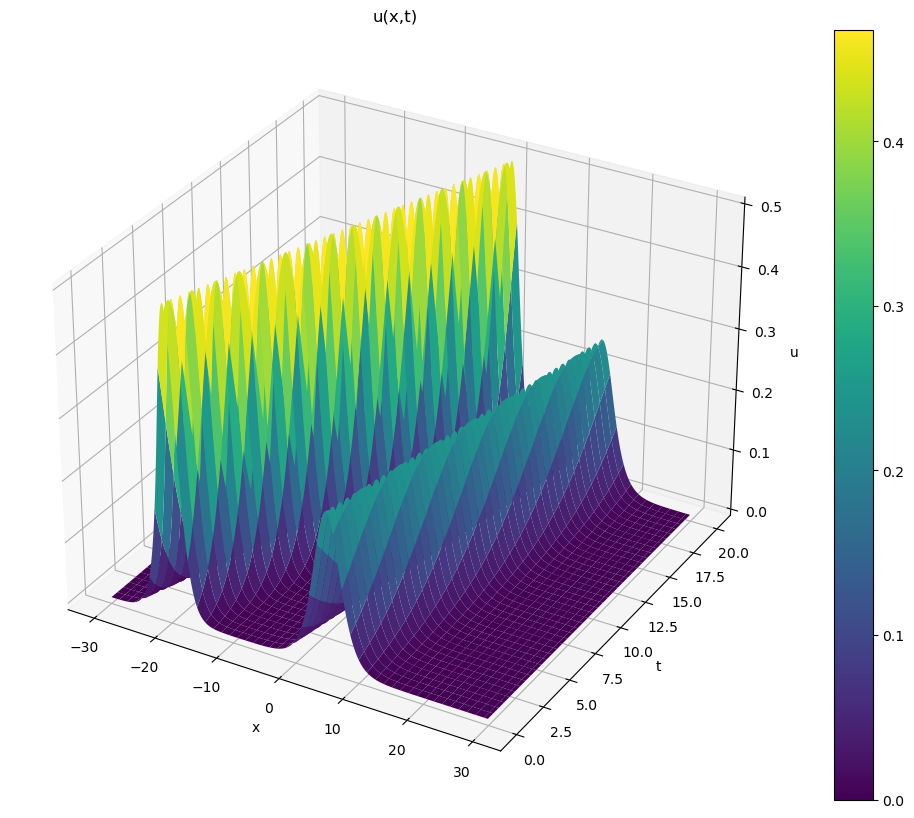

In [72]:


# Plot
fig = plt.figure()
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection="3d")
surf = ax.plot_surface(x, t, u, cmap="viridis")
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("u")
ax.set_title("u(x,t)")
fig.colorbar(surf)

plt.show()

Explore the data

In [66]:
t

array([[ 0. ,  0.1,  0.2, ..., 19.8, 19.9, 20. ],
       [ 0. ,  0.1,  0.2, ..., 19.8, 19.9, 20. ],
       [ 0. ,  0.1,  0.2, ..., 19.8, 19.9, 20. ],
       ...,
       [ 0. ,  0.1,  0.2, ..., 19.8, 19.9, 20. ],
       [ 0. ,  0.1,  0.2, ..., 19.8, 19.9, 20. ],
       [ 0. ,  0.1,  0.2, ..., 19.8, 19.9, 20. ]], dtype=float32)

In [67]:
x

array([[-30.      , -30.      , -30.      , ..., -30.      , -30.      ,
        -30.      ],
       [-29.882812, -29.882812, -29.882812, ..., -29.882812, -29.882812,
        -29.882812],
       [-29.765625, -29.765625, -29.765625, ..., -29.765625, -29.765625,
        -29.765625],
       ...,
       [ 29.648438,  29.648438,  29.648438, ...,  29.648438,  29.648438,
         29.648438],
       [ 29.765625,  29.765625,  29.765625, ...,  29.765625,  29.765625,
         29.765625],
       [ 29.882812,  29.882812,  29.882812, ...,  29.882812,  29.882812,
         29.882812]], dtype=float32)

We can notice that the data are distributed spatially and temporally with a nice pattern, composing a nice lattice. Finite Differenfce methods will be therefore a good and efficient way to find the derivatives of the function

In [68]:
# find out the spacing on the grid in x and t keeping 5 decimal places

print("t spacing:", np.mean(np.unique(np.diff(t[0])), axis=0, keepdims=True))
print("x spacing:", np.mean(np.unique(np.diff(x[:, 0])), axis=0, keepdims=True))

t spacing: [0.09999983]
x spacing: [0.1171875]


Therefore we choose a spacing of `0.01` for t and `0.1171875` for x

In [79]:
def derivatives_calculator(u, x, t, mixed=False):
    """
    Calculate the first, second and third order derivatives (sufficient according to hint) of u with respect to x and t

    Args:
    u: 2D array of shape (n_x, n_t)
    x: 1D array of shape (n_x,)
    t: 1D array of shape (n_t,)
    Returns:
    dict: A dictionary containing the first, second and third order derivatives of u with respect to x and t
          (it contains also mixed derivatives)

    """
    dx = 0.1171875
    dt = 0.1

    u_x = FinDiff(0, dx, 1)(u)
    u_t = FinDiff(1, dt, 1)(u)
    u_xx = FinDiff(0, dx, 2)(u)
    u_xxx = FinDiff(0, dx, 3)(u)

    if mixed:
        u_xt = FinDiff((0, 1), (dx, dt), 1)(u)
        u_xxt = FinDiff((0, 1), (dx, dt), 2)(u)
        u_xtt = FinDiff((0, 1), (dx, dt), 2)(u)

        return {
            "u": u,
            "u_x": u_x,
            "u_xx": u_xx,
            "u_xxx": u_xxx,
            "u_t": u_t,
            "u_xt": u_xt,
            "u_xxt": u_xxt,
            "u_xtt": u_xtt,
        }

    return {"u": u, "u_x": u_x, "u_xx": u_xx, "u_xxx": u_xxx, "u_t": u_t}


derivatives = derivatives_calculator(u, x, t)

In [80]:
def find_ut_Thetau(derivatives, degree):
    """
    Build the Theta matrix for the given derivatives up to a given degree.

    Args:
        derivatives (dict): Dictionary containing the derivatives of u with respect to x and t.
        degree (int): The maximum degree of the polynomial terms to include.

    Returns:
        np.ndarray: The Theta matrix containing the derivatives and polynomial terms.
        list: The descriptions of the columns in Theta.
    """

    # Extract and flatten u_t from the derivatives dictionary
    u_t = derivatives.pop("u_t").flatten()

    # Initialize the Theta matrix with a column of ones and the description list
    Theta_u = np.ones((len(u_t), 1))
    table = ["1"]

    # Include individual derivatives
    for key, value in derivatives.items():
        Theta_u = np.hstack([Theta_u, value.flatten().reshape(-1, 1)])
        table.append(key)

    # Generate polynomial terms up to the given degree
    for d in range(2, degree + 1):
        for combination in itertools.combinations_with_replacement(
            derivatives.keys(), d
        ):
            term = np.prod(
                [derivatives[deriv].flatten() for deriv in combination], axis=0
            )
            desc = " * ".join(combination)
            Theta_u = np.hstack([Theta_u, term.reshape(-1, 1)])
            table.append(desc)

    return u_t, Theta_u, table


u_t, Theta_u, Table = find_ut_Thetau(derivatives, degree=2)

# Print shapes for verification
print("u_t shape:", u_t.shape)
print("Theta shape:", Theta_u.shape)
print("Table:", Table)

u_t shape: (102912,)
Theta shape: (102912, 15)
Table: ['1', 'u', 'u_x', 'u_xx', 'u_xxx', 'u * u', 'u * u_x', 'u * u_xx', 'u * u_xxx', 'u_x * u_x', 'u_x * u_xx', 'u_x * u_xxx', 'u_xx * u_xx', 'u_xx * u_xxx', 'u_xxx * u_xxx']


In [82]:
xi = TrainSTRidge(R=Theta_u, Ut=u_t, lam=0.01, d_tol=0.09)
print("\n")

# print the name of the entries in the corresponding positios in the table list that correspond to the real part of the  xi vector >0.1
print("Significant_values:")
signif_values = []
for i, val in enumerate(xi):
    if np.abs(val) > 0.05:
        print(np.round(np.real(val), 2), Table[i])
        signif_values.append(Table[i])

Optimal tolerance: 2.2500000000000004


Significant_values:
-0.34 u_x
-0.59 u_xxx
-1.71 u * u_x
2.07 u * u_xxx
-4.39 u_x * u_xx


In [155]:
# We do some extra POST-HOC OPTIMIZATION with the candiates given above

u = derivatives["u"].flatten()
u_x = derivatives["u_x"].flatten()
u_xx = derivatives["u_xx"].flatten()
u_xxx = derivatives["u_xxx"].flatten()


def calculate_best(theta_dict, u_t, lamb = 0.5):
    """
    Calculate the best xi for the given list of theta values

    Args:
    theta_list: list of theta values
    u_t: target values
    Returns:
    np.ndarray: xi values
    """

    best_xi = None
    best_theta = None
    best_error = np.inf

    for key, value in theta_dict.items():
        xi = np.linalg.lstsq(value, u_t, rcond=None)[0]
        error = np.linalg.norm(value @ xi - u_t, 2) 
        # + lamb * np.sum(np.abs(xi))

        if error < best_error:
            best_error = error
            best_xi = xi
            best_theta = key

    print("Best error:", best_error, "\nfound for ", best_theta, "\nwith xi:", best_xi)

    return best_xi


# try all the combination of the significant values as singletons
theta_1 = np.array([u_x]).T
theta_2 = np.array([u_xxx]).T
theta_3 = np.array([u * u_x]).T
theta_4 = np.array([u * u_xxx]).T
theta_5 = np.array([u_x * u_xx]).T

singletons = {"u_x":theta_1, "u_xxx":theta_2, "u * u_x":theta_3, "u * u_xxx":theta_4, "u_x * u_xx":theta_5}

print("Singletons:")
best_xi = calculate_best(singletons, u_t)

# try all the combination of the significant values as pairs
theta_6 = np.array([u_x, u_xxx]).T
theta_7 = np.array([u_x, u * u_x]).T
theta_8 = np.array([u_x, u * u_xxx]).T
theta_9 = np.array([u_x, u_x * u_xx]).T
theta_10 = np.array([u_xxx, u * u_x]).T
theta_11 = np.array([u_xxx, u * u_xxx]).T
theta_12 = np.array([u_xxx, u_x * u_xx]).T
theta_13 = np.array([u * u_x, u * u_xxx]).T
theta_14 = np.array([u * u_x, u_x * u_xx]).T
theta_15 = np.array([u * u_xxx, u_x * u_xx]).T

pairs = {"u_x, u_xxx":theta_6, "u_x, u * u_x":theta_7, "u_x, u * u_xxx":theta_8, "u_x, u_x * u_xx":theta_9,
            "u_xxx, u * u_x":theta_10, "u_xxx, u * u_xxx":theta_11, "u_xxx, u_x * u_xx":theta_12,
            "u * u_x, u * u_xxx":theta_13, "u * u_x, u_x * u_xx":theta_14, "u * u_xxx, u_x * u_xx":theta_15}

print("\nPairs:")
best_xi = calculate_best(pairs, u_t)

# try all the combination of the significant values as triplets
theta_16 = np.array([u_x, u_xxx, u * u_x]).T
theta_17 = np.array([u_x, u_xxx, u * u_xxx]).T
theta_18 = np.array([u_x, u_xxx, u_x * u_xx]).T
theta_19 = np.array([u_x, u * u_x, u * u_xxx]).T
theta_20 = np.array([u_x, u * u_x, u_x * u_xx]).T
theta_21 = np.array([u_x, u * u_xxx, u_x * u_xx]).T
theta_22 = np.array([u_xxx, u * u_x, u * u_xxx]).T
theta_23 = np.array([u_xxx, u * u_x, u_x * u_xx]).T
theta_24 = np.array([u_xxx, u * u_xxx, u_x * u_xx]).T
theta_25 = np.array([u * u_x, u * u_xxx, u_x * u_xx]).T

triplets = {"u_x, u_xxx, u * u_x":theta_16, "u_x, u_xxx, u * u_xxx":theta_17, "u_x, u_xxx, u_x * u_xx":theta_18,
            "u_x, u * u_x, u * u_xxx":theta_19, "u_x, u * u_x, u_x * u_xx":theta_20, "u_x, u * u_xxx, u_x * u_xx":theta_21,
            "u_xxx, u * u_x, u * u_xxx":theta_22, "u_xxx, u * u_x, u_x * u_xx":theta_23, "u_xxx, u * u_xxx, u_x * u_xx":theta_24,
            "u * u_x, u * u_xxx, u_x * u_xx":theta_25}

print("\nTriplets:")
best_xi = calculate_best(triplets, u_t)

# try all the combination of the significant values as quadruplets
theta_26 = np.array([u_x, u_xxx, u * u_x, u * u_xxx]).T
theta_27 = np.array([u_x, u_xxx, u * u_x, u_x * u_xx]).T
theta_28 = np.array([u_x, u_xxx, u * u_xxx, u_x * u_xx]).T
theta_29 = np.array([u_x, u * u_x, u * u_xxx, u_x * u_xx]).T

quadruplets = {"u_x, u_xxx, u * u_x, u * u_xxx":theta_26, "u_x, u_xxx, u * u_x, u_x * u_xx":theta_27,
                "u_x, u_xxx, u * u_xxx, u_x * u_xx":theta_28, "u_x, u * u_x, u * u_xxx, u_x * u_xx":theta_29}

print("\nQuadruplets:")
best_xi = calculate_best(quadruplets, u_t)

# try all the combination of the significant values as quintuplets
theta_30 = np.array([u_x, u_xxx, u * u_x, u * u_xxx, u_x * u_xx]).T

quintuplets = {"u_x, u_xxx, u * u_x, u * u_xxx, u_x * u_xx":theta_30}

print("\nQuintuplets:")
best_xi = calculate_best(quintuplets, u_t)


Singletons:
Best error: 2.9287672 
found for  u_x 
with xi: [-0.9252378]

Pairs:
Best error: 0.8907329 
found for  u_xxx, u * u_x 
with xi: [-0.9881064 -5.956504 ]

Triplets:
Best error: 0.8525347 
found for  u_x, u_xxx, u * u_x 
with xi: [-0.07947016 -0.90624094 -5.463197  ]

Quadruplets:
Best error: 0.68414646 
found for  u_x, u_xxx, u * u_xxx, u_x * u_xx 
with xi: [-0.4722158  -0.44972712  2.970056   -6.1793604 ]

Quintuplets:
Best error: 0.64161146 
found for  u_x, u_xxx, u * u_x, u * u_xxx, u_x * u_xx 
with xi: [-0.33627012 -0.5920443  -1.7456166   2.0532265  -4.3619137 ]


It's clear to see that with a little regularization the best value of the candidates obtained by the given method is the one pair `[-0.9881064 -5.956504 ]` that gives rise to the PDE

$$ u_t = - 0.1 u_{xxx} - 6 uu_x $$

Which we know to be the KDV equation

# DATASET 3

In [91]:
data = np.load("AISE-project3-data/3.npz")


u = data["u"]
v = data["v"]
x = data["x"]
y = data["y"]
t = data["t"]



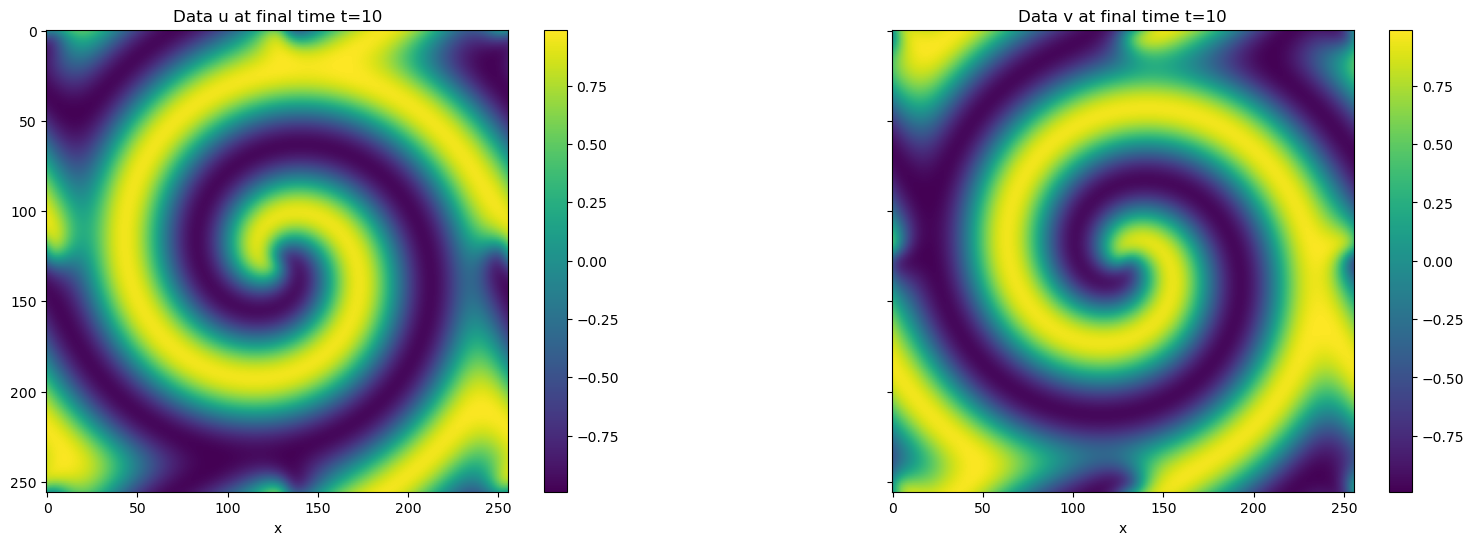

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6), sharey=True)

im1 = axs[0].imshow(data["u"][:, :, -1], cmap="viridis")
axs[0].set_xlabel("x")
axs[0].set_title("Data u at final time t=10")
fig.colorbar(im1, ax=axs[0])

im2 = axs[1].imshow(data["v"][:, :, -1], cmap="viridis")
axs[1].set_xlabel("x")
axs[1].set_title("Data v at final time t=10")
fig.colorbar(im2, ax=axs[1])

plt.tight_layout
plt.show()

In [93]:
t.shape, t

((256, 256, 201),
 array([[[ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         ...,
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ]],
 
        [[ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         ...,
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ]],
 
        [[ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
         ...,
         [ 0.  ,  0.05,  0.1 , ...,  9.9 ,  9.95, 10.  ],
      

In [94]:
x.shape, x

((256, 256, 201),
 array([[[-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ],
         [-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ],
         [-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ],
         ...,
         [-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ],
         [-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ],
         [-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ]],
 
        [[ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,
           -9.921875,  -9.921875],
         [ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,
           -9.921875,  -9.921875],
         [ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,
           -9.921875,  -9.921875],
         ...,
         [ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,
      

In [95]:
y.shape, y

((256, 256, 201),
 array([[[-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ],
         [ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,
           -9.921875,  -9.921875],
         [ -9.84375 ,  -9.84375 ,  -9.84375 , ...,  -9.84375 ,
           -9.84375 ,  -9.84375 ],
         ...,
         [  9.765625,   9.765625,   9.765625, ...,   9.765625,
            9.765625,   9.765625],
         [  9.84375 ,   9.84375 ,   9.84375 , ...,   9.84375 ,
            9.84375 ,   9.84375 ],
         [  9.921875,   9.921875,   9.921875, ...,   9.921875,
            9.921875,   9.921875]],
 
        [[-10.      , -10.      , -10.      , ..., -10.      ,
          -10.      , -10.      ],
         [ -9.921875,  -9.921875,  -9.921875, ...,  -9.921875,
           -9.921875,  -9.921875],
         [ -9.84375 ,  -9.84375 ,  -9.84375 , ...,  -9.84375 ,
           -9.84375 ,  -9.84375 ],
         ...,
         [  9.765625,   9.765625,   9.765625, ...,   9.765625,
      

In [96]:
# find out the spacing on the grid in x and t keeping 5 decimal places

print("t spacing:", np.mean(np.unique(np.diff(t[0, 0])), axis=0, keepdims=True))
print("x spacing:", np.mean(np.unique(np.diff(x[:,0, 0])), axis=0, keepdims=True))
print("y spacing:", np.mean(np.unique(np.diff(y[0, :, 0])), axis=0, keepdims=True))

t spacing: [0.04999992]
x spacing: [0.078125]
y spacing: [0.078125]


In [97]:
def derivatives_calculator(u, v, x, y, t, stride, third_order=False):
    """
    Calculate the first, second and third order derivatives (sufficient according to hint) of u and v with respect to x, y and t
    
    Args:
    u: 3D array of shape (n_x, n_y, n_t)
    v: 3D array of shape (n_x, n_y, n_t)
    x: 3D array of shape (n_x, n_y, n_t)
    y: 3D array of shape (n_x, n_y, n_t)
    t: 3D array of shape (n_x, n_y, n_t)

    Returns:
    dict: A dictionary containing the first, second and third order derivatives of u and v with respect to x, y and t
    """

    dx = 0.078125
    dy = 0.078125
    dt = 0.05


    u_x = FinDiff(0, dx, 1)(u)[::stride, ::stride, :]
    u_y = FinDiff(1, dy, 1)(u)[::stride, ::stride, :]
    u_t = FinDiff(2, dt, 1)(u)[::stride, ::stride, :]
    v_x = FinDiff(0, dx, 1)(v)[::stride, ::stride, :]
    v_y = FinDiff(1, dy, 1)(v)[::stride, ::stride, :]
    v_t = FinDiff(2, dt, 1)(v)[::stride, ::stride, :]

    u_xx = FinDiff(0, dx, 2,)(u)[::stride, ::stride, :]
    u_yy = FinDiff(1, dy, 2)(u)[::stride, ::stride, :]
    # u_xy = FinDiff((0, 1), (dx, dy), 1)(u)
    if third_order:
        u_xxx = FinDiff(0, dx, 3)(u)[::stride, ::stride, :]
        u_yyy = FinDiff(1, dy, 3)(u)[::stride, ::stride, :]
        # u_xxy = FinDiff((0, 1), (dx, dy), 2)(u)
        # u_xyy = FinDiff((0, 1), (dx, dy), 2)(u)

    v_xx = FinDiff(0, dx, 2)(v)[::stride, ::stride, :]
    v_yy = FinDiff(1, dy, 2)(v)[::stride, ::stride, :]
    # v_xy = FinDiff((0, 1), (dx, dy), 1)(v)
    if third_order:
        v_xxx = FinDiff(0, dx, 3)(v)[::stride, ::stride, :]
        v_yyy = FinDiff(1, dy, 3)(v)[::stride, ::stride, :]
        # v_xxy = FinDiff((0, 1), (dx, dy), 2)(v)
        # v_xyy = FinDiff((0, 1), (dx, dy), 2)(v)

    u = u[::stride, ::stride, :]
    v = v[::stride, ::stride, :]

    if third_order:
        return {
            "u": u,
            "v": v,
            "u_x": u_x,
            "u_y": u_y,
            "u_t": u_t,
            "v_x": v_x,
            "v_y": v_y,
            "v_t": v_t,
            "u_xx": u_xx,
            "u_yy": u_yy,
            # "u_xy": u_xy,
            "u_xxx": u_xxx,
            "u_yyy": u_yyy,
            # "u_xxy": u_xxy,
            # "u_xyy": u_xyy,
            "v_xx": v_xx,
            "v_yy": v_yy,
            # "v_xy": v_xy,
            "v_xxx": v_xxx,
            "v_yyy": v_yyy,
            # "v_xxy": v_xxy,
            # "v_xyy": v_xyy,
        }

    return { "u": u,
            "v": v,
            "u_x": u_x,
            "u_y": u_y,
            "u_t": u_t,
            "v_x": v_x,
            "v_y": v_y,
            "v_t": v_t,
            "u_xx": u_xx,
            "u_yy": u_yy,
            # "u_xy": u_xy,
            "v_xx": v_xx,
            "v_yy": v_yy,
            # "v_xy": v_xy
            }


derivatives = derivatives_calculator(u, v, x, y, t, stride=5)
print(derivatives.keys())

dict_keys(['u', 'v', 'u_x', 'u_y', 'u_t', 'v_x', 'v_y', 'v_t', 'u_xx', 'u_yy', 'v_xx', 'v_yy'])


In [98]:
#check that everything is in order (at least visually)
[print(key, value.shape, value) for key, value in derivatives.items()]

u (52, 52, 201) [[[-0.7035847  -0.7035847  -0.23083949 ...  0.00156755  0.00473646
    0.00788847]
  [-0.8790234  -0.8790234  -0.41868246 ... -0.03517666 -0.00947167
    0.01625068]
  [-0.9783352  -0.9783352  -0.5657659  ...  0.16924651  0.20394042
    0.238298  ]
  ...
  [-0.23886757 -0.23886757  0.19472833 ... -0.13371232 -0.16874439
   -0.20350452]
  [-0.46787325 -0.46787325  0.0162482  ...  0.07207101  0.04664577
    0.02112841]
  [-0.6736629  -0.6736629  -0.18186715 ...  0.03515434  0.03281911
    0.03041898]]

 [[-0.85933834 -0.85933834 -0.7258444  ... -0.5814788  -0.5811182
   -0.5798124 ]
  [-0.97182566 -0.97182566 -0.95422465 ... -0.48646423 -0.4628686
   -0.4385068 ]
  [-0.9984238  -0.9984238  -0.9952071  ... -0.17954576 -0.14341457
   -0.10703509]
  ...
  [ 0.06433482  0.06433482  0.01417617 ... -0.54592276 -0.57437056
   -0.6018597 ]
  [-0.18580523 -0.18580523 -0.23368174 ... -0.5012173  -0.5232857
   -0.54450196]
  [-0.43016863 -0.43016863 -0.5824155  ... -0.5679634  -0.57

[None, None, None, None, None, None, None, None, None, None, None, None]

In [99]:
def find_ut_Thetau(derivatives, degree, fast=False):
    """
    Build the Theta matrix for the given derivatives up to a given degree

    Args:
    derivatives: dict containing the derivatives of u with respect to x and t
    P: int, the maximum degree of the polynomial terms to include
    Returns:
    np.ndarray: The Theta matrix containing the derivatives and polynomial terms
    list: The descriptions of the columns in Theta

    """

    u_t = derivatives.pop("u_t").flatten()
    v_t = derivatives.pop("v_t").flatten()

    Theta_u = np.ones((derivatives["u"].flatten().shape[0], 1))
    table = ["1"]

    # Include individual derivatives
    for key, value in derivatives.items():
        Theta_u = np.hstack([Theta_u, value.reshape(-1, 1)])
        table.append(key)

    # needed as otherwise this methd takes too long
    if fast:
        for d in range(2, degree + 1):
            for combination in itertools.combinations_with_replacement(["u", "v"], d):
                term = np.ones(derivatives["u"].flatten().shape[0])
                desc = ""
                for deriv in combination:
                    term *= derivatives[deriv].flatten()
                    desc += deriv + " * "
                Theta_u = np.hstack([Theta_u, term.reshape(-1, 1)])
                table.append(desc.strip(" * "))

    # Polynomial terms (up to selected degree)
    else:
        for d in range(2, degree + 1):
            for combination in itertools.combinations_with_replacement(
                derivatives.keys(), d
            ):
                term = np.ones(derivatives["u"].flatten().shape[0])
                desc = ""
                for deriv in combination:
                    term *= derivatives[deriv].flatten()
                    desc += deriv + " * "
                Theta_u = np.hstack([Theta_u, term.reshape(-1, 1)])
                table.append(desc.strip(" * "))

    return u_t, v_t, Theta_u, table


u_t, v_t, Theta_u, Table = find_ut_Thetau(derivatives, degree=3, fast = False)

# Print shapes for verification
print("u_t shape:", u_t.shape)
print("Theta shape:", Theta_u.shape)
print("Theta shape:", Theta_u.shape)
print("Table:", Table)

u_t shape: (543504,)
Theta shape: (543504, 286)
Theta shape: (543504, 286)
Table: ['1', 'u', 'v', 'u_x', 'u_y', 'v_x', 'v_y', 'u_xx', 'u_yy', 'v_xx', 'v_yy', 'u * u', 'u * v', 'u * u_x', 'u * u_y', 'u * v_x', 'u * v_y', 'u * u_xx', 'u * u_yy', 'u * v_xx', 'u * v_yy', 'v * v', 'v * u_x', 'v * u_y', 'v * v_x', 'v * v_y', 'v * u_xx', 'v * u_yy', 'v * v_xx', 'v * v_yy', 'u_x * u_x', 'u_x * u_y', 'u_x * v_x', 'u_x * v_y', 'u_x * u_xx', 'u_x * u_yy', 'u_x * v_xx', 'u_x * v_yy', 'u_y * u_y', 'u_y * v_x', 'u_y * v_y', 'u_y * u_xx', 'u_y * u_yy', 'u_y * v_xx', 'u_y * v_yy', 'v_x * v_x', 'v_x * v_y', 'v_x * u_xx', 'v_x * u_yy', 'v_x * v_xx', 'v_x * v_yy', 'v_y * v_y', 'v_y * u_xx', 'v_y * u_yy', 'v_y * v_xx', 'v_y * v_yy', 'u_xx * u_xx', 'u_xx * u_yy', 'u_xx * v_xx', 'u_xx * v_yy', 'u_yy * u_yy', 'u_yy * v_xx', 'u_yy * v_yy', 'v_xx * v_xx', 'v_xx * v_yy', 'v_yy * v_yy', 'u * u * u', 'u * u * v', 'u * u * u_x', 'u * u * u_y', 'u * u * v_x', 'u * u * v_y', 'u * u * u_xx', 'u * u * u_yy', 'u * u * 

In [26]:
xi_1 = TrainSTRidge(R=Theta_u, Ut=u_t, lam=0.01, d_tol=0.1)
xi_2 = TrainSTRidge(R=Theta_u, Ut=v_t, lam=0.01, d_tol=0.1)

# This code took 20 mins to run on my machine

Optimal tolerance: 0.9999999999999999
Optimal tolerance: 1.6000000000000003
(293,)
(293,)
[ 0.00000000e+00  5.68427624e-01  1.23927713e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -6.38543851e-02  3.64125097e-02  4.53752942e-02  0.00000000e+00
  0.00000000e+00 -1.47577603e-02  1.76147243e-03  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.40933126e-02 -6.12461939e-04  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  2.66222710e-03  0.00000000e+00
 -2.54862047e-03  0.00000000e+00  0.00000000e+00  4.78225806e-04
  0.00000000e+00 -3.91206445e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  3.59895545e-03  0.00000000e+00  0.00000000e+00


In [31]:
# print the name of the entries in the corresponding positios in the table list that correspond to the real part of the  xi vector >0.1
print("Significant_values 1:")
signif_values_1 = []
for i, val in enumerate(xi_1):
    if np.abs(val) > 0.06:
        print(np.round(np.real(val), 2), Table[i])
        signif_values_1.append(Table[i])

print("Significant_values 2:")
signif_values_2 = []
for i, val in enumerate(xi_2):
    if np.abs(val) > 0.06:
        print(np.round(np.real(val), 2), Table[i])
        signif_values_2.append(Table[i])

Significant_values 1:
0.57 u
1.24 v
-0.06 u_yy
-0.28 u * u * u
-0.16 u * u * v
0.08 u * u * u_xx
0.17 u * u * u_yy
-0.29 u * v * v
0.1 u * u_x * v_y
-0.14 u * u_y * u_y
-0.09 u * u_y * v_x
-0.08 u * u_y * v_y
-0.12 v * v * v
0.09 v * v * u_xx
0.18 v * v * u_yy
-0.07 v * u_x * u_x
-0.07 v * u_y * u_y
-0.23 v * u_y * v_y
-0.16 v * v_y * v_y
-0.28 u * u * u
-0.16 u * u * v
-0.29 u * v * v
-0.12 v * v * v
Significant_values 2:
-0.84 u
0.48 v
-0.07 u * u * u
-0.26 u * u * v
-0.08 u * u * u_xx
0.09 u * u * v_xx
0.08 u * u * v_yy
-0.06 u * u_x * v_x
-0.24 v * v * v
0.06 v * v * v_xx
0.07 v * v * v_yy
-0.06 v * u_x * v_x
-0.07 u * u * u
-0.26 u * u * v
-0.24 v * v * v


We might therefore think that we have in front of us a case of coupled reaction diffusion, we therefore try to rerun the analysis again but this time with a smaller library

In [33]:
derivatives = derivatives_calculator(u, v, x, y, t, stride=5)


def find_ut_Thetau(derivatives, degree, fast=False):
    """
    Build the Theta matrix for the given derivatives up to a given degree

    Args:
    derivatives: dict containing the derivatives of u with respect to x and t
    P: int, the maximum degree of the polynomial terms to include
    Returns:
    np.ndarray: The Theta matrix containing the derivatives and polynomial terms
    list: The descriptions of the columns in Theta

    """

    u_t = derivatives.pop("u_t").flatten()
    v_t = derivatives.pop("v_t").flatten()

    Theta_u = np.ones((derivatives["u"].flatten().shape[0], 1))
    table = ["1"]

    # Include individual derivatives
    for key, value in derivatives.items():
        Theta_u = np.hstack([Theta_u, value.reshape(-1, 1)])
        table.append(key)

    if fast:
        for d in range(2, degree + 1):
            for combination in itertools.combinations_with_replacement(["u", "v"], d):

                term = np.prod(
                [derivatives[deriv].flatten() for deriv in combination], axis=0
                )
                desc = " * ".join(combination)
                Theta_u = np.hstack([Theta_u, term.reshape(-1, 1)])
                table.append(desc)

    # Polynomial terms (up to selected degree)
    else:
        for d in range(2, degree + 1):
            for combination in itertools.combinations_with_replacement(
                derivatives.keys(), d
            ):
                term = np.prod(
                    [derivatives[deriv].flatten() for deriv in combination], axis=0
                )
                desc = " * ".join(combination)
                Theta_u = np.hstack([Theta_u, term.reshape(-1, 1)])
                table.append(desc)

    return u_t, v_t, Theta_u, table


u_t, v_t, Theta_u, Table = find_ut_Thetau(derivatives, degree=3, fast=True)

# Print shapes for verification
print("u_t shape:", u_t.shape)
print("Theta shape:", Theta_u.shape)
print("Theta shape:", Theta_u.shape)
print("Table:", Table)

u_t shape: (543504,)
Theta shape: (543504, 18)
Theta shape: (543504, 18)
Table: ['1', 'u', 'v', 'u_x', 'u_y', 'v_x', 'v_y', 'u_xx', 'u_yy', 'v_xx', 'v_yy', 'u * u', 'u * v', 'v * v', 'u * u * u', 'u * u * v', 'u * v * v', 'v * v * v']


In [41]:
xi_1_new = TrainSTRidge(R=Theta_u, Ut=u_t, lam=0.01, d_tol=0.05)
xi_2_new = TrainSTRidge(R=Theta_u, Ut=v_t, lam=0.01, d_tol=0.05)

Optimal tolerance: 1.2500000000000004
Optimal tolerance: 1.2500000000000004


In [45]:
# print the name of the entries in the corresponding positios in the table list that correspond to the real part of the  xi vector >0.1
print("Significant_values 1:")
signif_values_1 = []
for i, val in enumerate(xi_1_new):
    if np.abs(val) > 0.06:
        print(np.round(np.real(val), 2), Table[i])
        signif_values_1.append(Table[i])

print("\n")

print("Significant_values 2:")
signif_values_2 = []
for i, val in enumerate(xi_2_new):
    if np.abs(val) > 0.06:
        print(np.round(np.real(val), 2), Table[i])
        signif_values_2.append(Table[i])

Significant_values 1:
1.0 u
0.18 v
0.1 u_xx
0.1 u_yy
-1.0 u * u * u
0.78 u * u * v
-1.0 u * v * v
0.78 v * v * v


Significant_values 2:
-0.18 u
1.01 v
0.1 v_xx
0.1 v_yy
-0.78 u * u * u
-1.01 u * u * v
-0.78 u * v * v
-1.01 v * v * v


Now we also get a nicely symetric set of PDEs that is more likely to explain the data. The resulting set of PDEs will therefore be 

$$ u_t = u + 0.18 v + 0.1 u_{xx} + 0.1 u_{yy} - uuu + 0.78 uuv  - uvv + 0.78 vvv $$
$$ v_t = - 0.18 u + v + 0.1 v_{xx} + 0.1 v_{yy} - 0.78 uuu - uuv  - 0.78 uvv - vvv $$